In [ ]:
%pip install --upgrade pip FLAML "flaml[spark]" setuptools wheel optuna optuna-integration openml xgboost catboost imbalanced-learn
# %pip install --upgrade "scikit-learn==1.1.2"
# %pip list

In [1]:
# To allow own package to be imported
import sys
import os
if os.path.dirname(os.getcwd()) not in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from warnings import filterwarnings
filterwarnings(action = "ignore")

# import necessary packages
import pandas as pd
import numpy as np
import polars as pl
import plotly.express as px
import wh0102 as mphd

# Prepare the data dictionary
data_dictionary = {
    "Ethnic":{0:"Malay", 1:"Chinese", 2:"Indian"},
    "bmi":{0:"Normal BMI", 1:"Overweight"},
    "Disease":{0:"No liver disease", 1:"Have Liver Disease"},
    "Gender":{0:"Female", 1:"Male"}
}

# Rename for easier references
column_to_be_rename = {"Sgot":"ALT",
                       "Sgpt":"AST",
                       "Alkphos":"ALP"}

# Prepare the variables
dependent_variable = "Disease"
independent_demographic = ("Age", "Gender", "Ethnic", "bmi",)
independent_investigations = ("AGR", "ALB", "TP", "TB", "DB", "ALP", "ALT", "AST",)
independent_continous = (independent_demographic[0],) + independent_investigations
independent_categorical = independent_demographic[1:]
independent_variables = independent_demographic + independent_investigations

# Load the data
df = pd.read_csv(r"assignment4.csv")

# Rename the column name
df = df.rename(columns = column_to_be_rename)

# To reassign the categorical value
for column in [key for key in data_dictionary.keys() if key != "Gender"]:
    df.loc[:,column] = df.loc[:,column] - 1

# Print the information
df.info()

# To delete after this
# missing_df = mphd.missing_values.analyse_missing_row(df)
# df = mphd.categorical_data.label_encode(df = df, columns = "Gender", convert_numeric=True)
# df = mphd.missing_values.mice_imputation(df = df, columns = "AGR")
# df.drop(columns = ["Patient_ID"]).to_csv(r"imputed_assignment_4.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  553 non-null    int64  
 1   Age         553 non-null    int64  
 2   TB          553 non-null    float64
 3   DB          553 non-null    float64
 4   ALP         553 non-null    int64  
 5   ALT         553 non-null    int64  
 6   AST         553 non-null    int64  
 7   TP          553 non-null    float64
 8   ALB         553 non-null    float64
 9   AGR         553 non-null    object 
 10  Disease     553 non-null    int64  
 11  Ethnic      553 non-null    int64  
 12  Gender      553 non-null    object 
 13  bmi         553 non-null    int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 60.6+ KB


In [2]:
# Convert the gender
df = mphd.categorical_data.label_encode(df = df, columns = "Gender", convert_numeric=True)
# "Gender":{0:"Female", 1:"Male"}

# Check for duplication
duplicated_df, to_drop_duplicated_df = mphd.pre_processing.check_duplication(df)

# Check for missing value
missing_df = mphd.missing_values.analyse_missing_row(df)
missing_df

No duplication found in the dataset.
Missing data detected for columns AGR.
Summary of the missing values from the dataframe =
+------------------------------+-------+--------------------+
|                              | count | missing_percentage |
+------------------------------+-------+--------------------+
|             AGR              |  4.0  |        0.72        |
| All_rows_with_missing_values |  4.0  |        0.72        |
+------------------------------+-------+--------------------+


,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,NaN,0,0,0,0
160,161,51,0.8,0.2,230,46,24,6.5,3.1,NaN,0,0,1,0
450,451,35,0.6,0.2,180,15,12,5.2,2.7,NaN,1,2,0,1
468,469,27,1.3,0.6,106,54,25,8.5,4.8,NaN,1,0,1,0


## To fix AGR == ' ' issue

In [3]:
# Calculate the Globulin for every patient ID with globulin = tp - alb based on resource below:
# https://www.ncbi.nlm.nih.gov/books/NBK204/#:~:text=The%20total%20globulin%20fraction%20is,of%20further%20fractionating%20serum%20proteins

# To check the truthness of this on the data
# Create a deep copy of the df with AGR not null first
temp_df = df.query("AGR.notnull()").copy(deep = True)

# Calculatet the globulin and agr_ratio
def calculate_agr(df:pd.DataFrame, column_name:str):
    df.loc[:,column_name] = df.loc[:,"ALB"] / (df.loc[:,"TP"] - df.loc[:,"ALB"])
    return df

# Calculate the approximate agr
temp_df = calculate_agr(df = temp_df, column_name = "agr_new")
# Check for float similarity
temp_df.loc[:,"agr_similarity"] = temp_df.loc[:,("AGR", "agr_new",)].apply(lambda x: np.isclose(float(x[0]), x[1], rtol = 0.1), axis = 1)

# Pivot the information
pt = temp_df.pivot_table(index = "agr_similarity", values = "Patient_ID", aggfunc = len, margins = True).rename(columns={"Patient_ID":"count"})
# Calculate percentage
pt.loc[:,"percentage"] = round(pt.loc[:,"count"] / pt.loc["All", "count"] * 100, 2)

print(pt.to_markdown(tablefmt = "pretty"))

# Check on the not similarity result
temp_df.query("agr_similarity == False")

+----------------+-------+------------+
| agr_similarity | count | percentage |
+----------------+-------+------------+
|     False      | 48.0  |    8.74    |
|      True      | 501.0 |   91.26    |
|      All       | 549.0 |   100.0    |
+----------------+-------+------------+


,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi,agr_new,agr_similarity
9,10,72,2.7,1.3,260,56,31,7.4,3.0,0.6,0,0,1,1,0.681818,False
32,33,45,0.7,0.2,170,14,21,5.7,2.5,0.7,0,0,0,1,0.781250,False
49,50,75,0.8,0.2,188,29,20,4.4,1.8,0.6,0,0,0,0,0.692308,False
63,64,60,6.8,3.2,308,794,404,6.8,3.0,0.7,0,0,1,1,0.789474,False
64,65,60,8.6,4.0,298,850,412,7.4,3.0,0.6,0,0,1,0,0.681818,False
91,92,66,4.2,2.1,159,30,15,7.1,2.2,0.4,0,0,0,0,0.448980,False
130,131,60,2.4,1.0,1124,54,30,5.2,1.9,0.5,0,0,1,0,0.575758,False
133,134,7,27.2,11.8,1420,1050,790,6.1,2.0,0.4,0,0,0,0,0.487805,False
139,140,70,0.9,0.3,220,95,53,6.1,2.8,0.68,0,0,0,0,0.848485,False
164,165,55,1.8,9.0,272,79,22,6.1,2.7,0.7,0,0,1,0,0.794118,False


In [4]:
# Trial to impute with calculation
missing_df = calculate_agr(df = missing_df, column_name="AGR")
missing_df

,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,1.444444,0,0,0,0
160,161,51,0.8,0.2,230,46,24,6.5,3.1,0.911765,0,0,1,0
450,451,35,0.6,0.2,180,15,12,5.2,2.7,1.08,1,2,0,1
468,469,27,1.3,0.6,106,54,25,8.5,4.8,1.297297,1,0,1,0


In [5]:
# Impute with MICE
# https://medium.com/@brijesh_soni/topic-9-mice-or-multivariate-imputation-with-chain-equation-f8fd435ca91#:~:text=MICE%20stands%20for%20Multivariate%20Imputation,produce%20a%20final%20imputed%20dataset.

df = mphd.missing_values.mice_imputation(df = df, columns = "AGR")
# Check on the imputated value
df.loc[missing_df.index]

,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,1.299105,0,0,0,0
160,161,51,0.8,0.2,230,46,24,6.5,3.1,0.908333,0,0,1,0
450,451,35,0.6,0.2,180,15,12,5.2,2.7,1.006441,1,2,0,1
468,469,27,1.3,0.6,106,54,25,8.5,4.8,1.361591,1,0,1,0


__intepretation__:

For imputation, despite the logic of how AGR being calculated, there is a lot of noise in the data for AGR value, therefore we would use MICE for imputation.

In [6]:
# Reverse Encode
data = mphd.categorical_data.reverse_encode(df = df, json_dict=data_dictionary)
data

,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
0,1,58,1.0,0.4,182,20,14,6.8,3.4,1.00,No liver disease,Malay,Male,Overweight
1,2,46,1.8,0.7,208,14,19,7.6,4.4,1.30,No liver disease,Malay,Male,Normal BMI
2,3,26,0.9,0.2,154,12,16,7.0,3.5,1.00,No liver disease,Malay,Female,Normal BMI
3,4,29,0.9,0.3,202,11,14,6.7,3.6,1.10,No liver disease,Malay,Female,Normal BMI
4,5,65,0.7,0.1,187,18,16,6.8,3.3,0.90,No liver disease,Malay,Female,Normal BMI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,549,29,1.2,0.4,160,22,20,6.2,3.0,0.90,Have Liver Disease,Malay,Male,Normal BMI
549,550,38,0.6,0.1,165,34,22,5.9,2.9,0.90,Have Liver Disease,Malay,Female,Overweight
550,551,50,1.0,0.3,191,31,22,7.8,4.0,1.00,Have Liver Disease,Malay,Female,Overweight
551,552,60,0.5,0.1,500,34,20,5.9,1.6,0.37,Have Liver Disease,Malay,Male,Normal BMI


## Continous Data

+-----------------+------------+----------+---------+---------+------------+------------+------------+---------+---------+--------+---------+---------+---------+---------+
|                 | Patient_ID |   Age    |   TB    |   DB    |    ALP     |    ALT     |    AST     |   TP    |   ALB   |  AGR   | Disease | Ethnic  | Gender  |   bmi   |
+-----------------+------------+----------+---------+---------+------------+------------+------------+---------+---------+--------+---------+---------+---------+---------+
|      count      |   553.0    |  553.0   |  553.0  |  553.0  |   553.0    |   553.0    |   553.0    |  553.0  |  553.0  | 553.0  |  553.0  |  553.0  |  553.0  |  553.0  |
|      mean       |   277.0    |  44.425  | 3.1318  |  1.462  |  286.3779  |  111.8101  |  81.4991   | 6.4801  | 3.1472  | 0.953  | 0.3074  | 0.7541  | 0.7523  |  0.358  |
|       std       |  159.7816  | 16.0055  | 5.4053  | 2.7846  |  239.5825  |  295.6858  |  186.8426  |  1.083  | 0.7888  | 0.3189 | 0.4618  

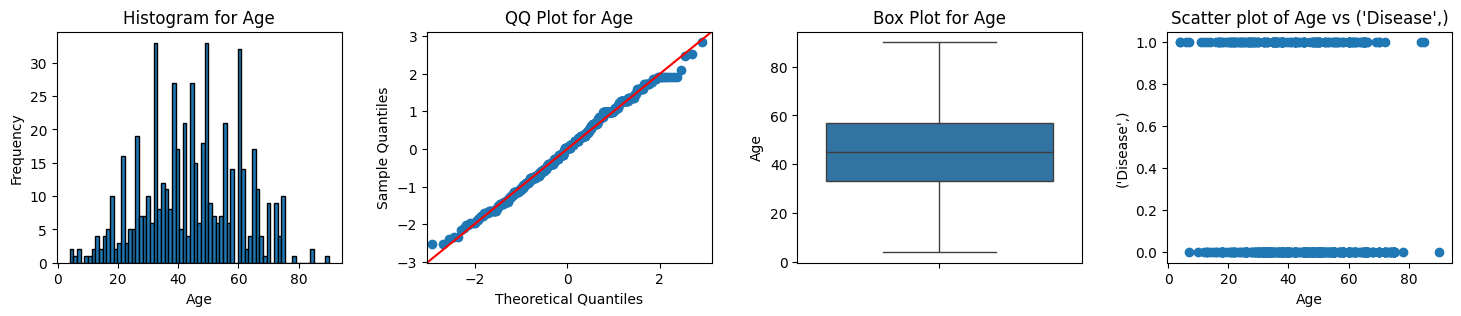

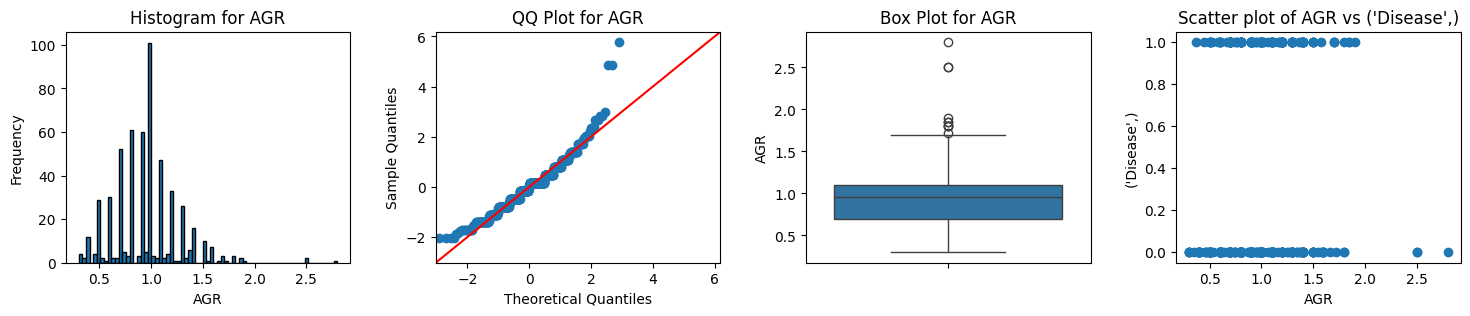

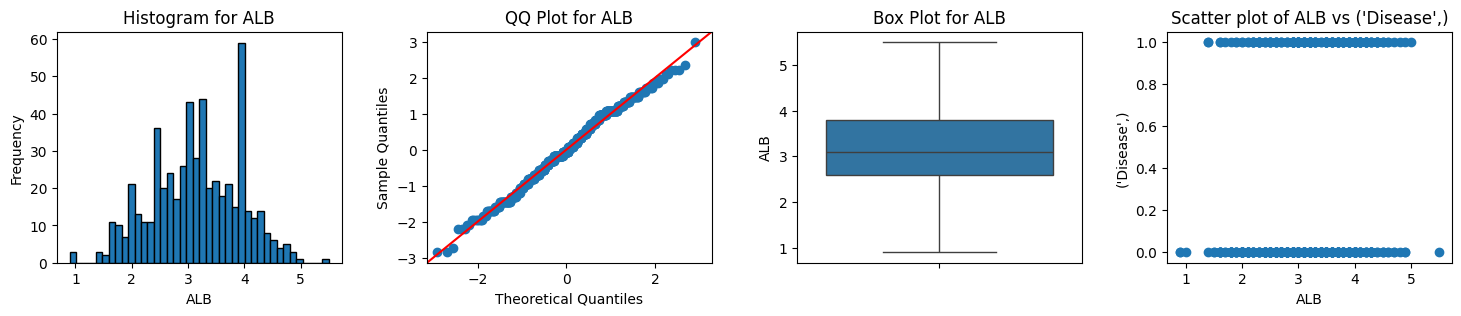

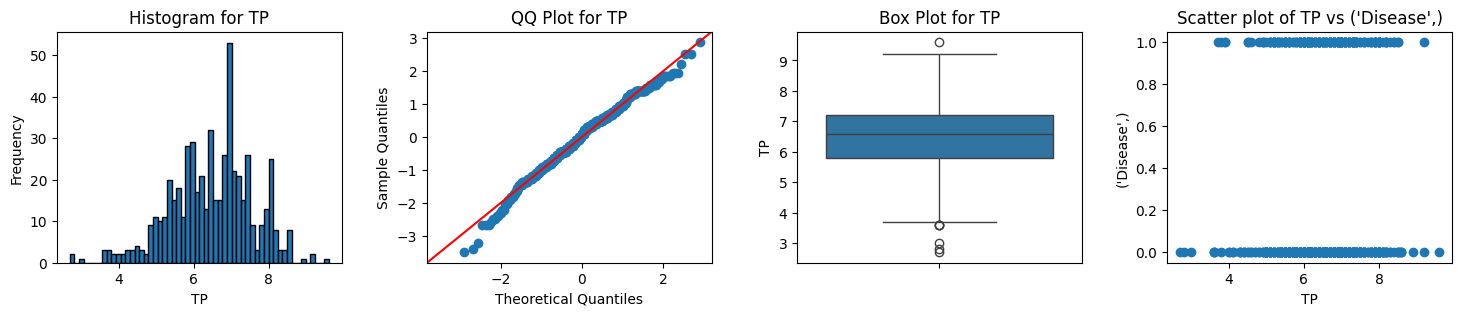

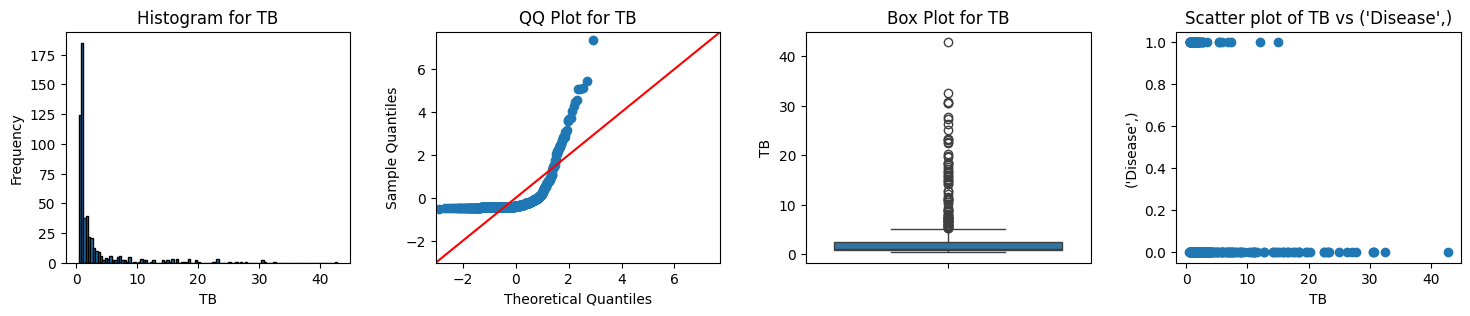

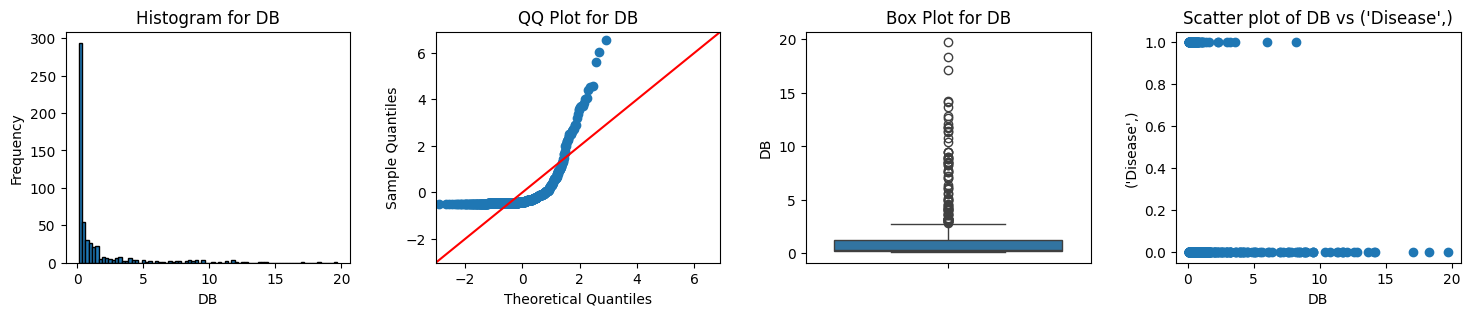

In [7]:
# Check for normal distribution
normal_distribution_list, abnormal_distribution_list = mphd.continous_data.descriptive_analysis(df = df, 
                                                                                                independent_variables=independent_continous, 
                                                                                                dependent_variables = dependent_variable,
                                                                                                descriptive_type = "continous",
                                                                                                plot_dependent_variables = False,
                                                                                                plot_correlation = False, 
                                                                                                round = 4)

In [ ]:
# Show outliers with 1.5 * std
outliers_df = mphd.continous_data.identify_outliers(df = df, column_name = ["TP", "TB", "ALP", "AST", "ALT"], num_stds = 2.5)

## Categorical Data

In [ ]:
categorical_summary = mphd.categorical_data.categorical_descriptive_analysis(data,
                                                                             independent_variables = independent_categorical, 
                                                                             dependent_variables = dependent_variable, 
                                                                             analyse_dependent = True)

## Model Training

In [ ]:
X_train, X_test, y_train, y_test = mphd.pre_processing.train_test_split(df = df,
                                                                        independent_variables=independent_variables,
                                                                        dependent_variable = dependent_variable,
                                                                        test_size = 0.2)
# "estimator_list": ['lgbm', 'lgbm_spark', 'xgboost', 'catboost', 'rf'],
    # "task": 'regression',  # task type    
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'roc_auc',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm',],  # list of ML learners; we tune lightgbm in this example
    "task": 'classification',  # task type    
    "log_file_name": None,  # flaml log file
    "seed": 7654321,    # random seed
    "use_spark": True,  # whether to use Spark for distributed training
    "n_concurrent_trials": 2,  # the maximum number of concurrent trials
}

automl = mphd.machine_learning.automl(X_train=X_train, y_train=y_train, **settings)

In [ ]:
mphd.analyse_ml.analyse_automl(automl=automl, X_test = X_test, y_test = y_test)
automl.model.estimator

In [ ]:
# Logistic Regression
# set acceptable p value
acceptable_p_value = 0.05

# For binominal logistic regression with 2 different depression score outcome along with all independent variable are categorized
logistic_models, summary_logistic_models = mphd.regression.regression_list(df = df, mode = "sm.Logit",
                                                                                   independent_variables = independent_demographic + independent_investigations,
                                                                                   dependent_variables = dependent_variable,
                                                                                   p_value_cut_off = acceptable_p_value)

# To display some information
columns_to_display = ("pseudo_r_2", "log_likelihood", "llr_p_value", "aic_akaike_information_criterion", "bic_bayesin_information_criterion", "coeff_all_significant")
summary_logistic_short = mphd.regression.analyse_model_summary(summary_logistic_models.loc[:,("variables", "num_variables") + columns_to_display + 
                                                                                      ("roc", "shapiro_residual", 
                                                                                       "Lagrange_Multiplier", "Lagrange_Multiplier_p-value",
                                                                                       "F-statistic", "F-statistic_p-value")], 
                                                      top_count = 3,
                                                      parameters= {"aic_akaike_information_criterion": True,
                                                                   "bic_bayesin_information_criterion": True,
                                                                   "pseudo_r_2": False, 
                                                                   "roc":False})
print(summary_logistic_short.round(4).to_markdown(tablefmt = "pretty"))
print(logistic_models[2893].summary())

In [ ]:
# import optuna.integration.lightgbm as lgb
from optuna.integration import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score

dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)],
)

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
accuracy = accuracy_score(y_test, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [ ]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

num_cols = ['age', 'bmi', 'sys_bp', 'dias_bp', 'hba1c', 'ldl']
cat_cols = ['sex', 'ethnic', 'retinopathy', 'ihd', 'cevd', 'nephropathy']

n_estimators = [100, 300]
max_depth = [3,4,5]
min_child_weight = range(1,3,1)
booster = ['gbdt']
base_score = [0.5,0.6]
learning_rate = [0.1,0.2]
objective = ['binary']
seed = [27]
gamma= [0.7,0.8,0.9]
colsample_bytree=[0.7,0.8,0.9]
subsample=[0.6,0.7,0.8]
reg_alpha = [1e-5,0.01,0.03]
weights = np.linspace(0.3, 0.9, 2)
num_leaves = [6]

lgbm_params = {'classifier__n_estimators': n_estimators, 'classifier__max_depth': max_depth,
               'classifier__learning_rate' : learning_rate, 'classifier__min_child_weight' : min_child_weight, 
               'classifier__boosting_type' : booster, 'classifier__seed':seed,'smote__sampling_strategy': weights,
               'classifier__reg_alpha':reg_alpha, 'classifier__num_leaves':num_leaves}

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,independent_demographic+independent_investigations],
                                                    df.loc[:,dependent_variable],
                                                    test_size=0.2,
                                                    stratify=df.loc[:,dependent_variable],
                                                    random_state=11)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), independent_continous),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([('smote', SMOTE(random_state=11)),
                     ('scaler', preprocessor),
                     ('classifier', LGBMClassifier())])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = lgbm_params
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

model = grid_search.fit(X_train, y_train, num_boost_round=1000, early_stopping_rounds=50, verbose_eval=100)
model.predict(X_test)